*Importing all the libraries we will be using in our project*

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output

*Giving user the ability to create own dataset*

In [6]:
#Our Custom Dataframe
df=pd.DataFrame()
# Function to calculate and display the results
def calculate_and_display(lambda_nm, I_0, r, n, d):
    # Convert wavelength from nanometers to meters
    lambda_m = lambda_nm * 1e-9

    # Condition for Rayleigh scattering:
    if r >= lambda_m:
        raise ValueError("Rayleigh scattering condition not satisfied.\nRadius of particle r should not be greater than the wavelength of light λ")

    # Scattering angles in degrees (from 0 to 180 degrees) with a step size of 0.1
    theta_degrees = np.arange(0, 180.1, 0.1)

    # Convert scattering angles from degrees to radians
    theta_radians = np.deg2rad(theta_degrees)

    # Calculate the Rayleigh scattering intensity for each scattering angle
    intensity_parallel = I_0*(16*np.pi**4 * r**6 / (lambda_m**4 * d**2)) * ((n**2 - 1) / (n**2 + 2))**2 * (np.cos(theta_radians))**2
    intensity_perpendicular = I_0 * (16 * np.pi**4 * r**6 / (lambda_m**4 * d**2)) * ((n**2 - 1) / (n**2 + 2))**2
    intensity_perpendicular = np.full_like(theta_degrees, intensity_perpendicular)

    # Calculate unpolarized intensity as the average of parallel and perpendicular
    intensity_unpolarized = (intensity_parallel + intensity_perpendicular) / 2

    # Create a DataFrame
    df1 = pd.DataFrame({
        'angle': theta_degrees,
        'parallel': intensity_parallel,
        'perpendicular': intensity_perpendicular,
        'unpolarized': intensity_unpolarized
    })
    global df
    df=df1.copy()
    # Display the DataFrame
    display(df)

    # Plot the graph
    plt.figure(figsize=(10, 6))
    plt.style.use('ggplot')
    plt.plot(theta_degrees, intensity_parallel, color='red', label='Parallel Polarization')
    plt.plot(theta_degrees, intensity_perpendicular, color='red', linestyle='--', label='Perpendicular Polarization')
    plt.plot(theta_degrees, intensity_unpolarized, color='blue', label='Unpolarized')
    plt.xlabel('Scattering Angle (degrees)', color='black')
    plt.ylabel('Intensity', color='black')
    plt.xlim(0, 180)
    plt.xticks(np.arange(0, 181, 30))
    plt.title('Rayleigh Scattering Intensity vs Scattering Angle', fontweight='bold', fontname='Franklin Gothic Medium')

    columnLabels = ['Input Parameters', 'Values']
    tableValues = [['λ', f' {lambda_nm} nm'], ['Radius of particle(r)', f'{r*1e6} μm'], ['Ref. Index(n)', n],['Observer Distance', f'{d} m'], ['Incident Intensity I\u2080', f'{I_0} (W/m\u00B2)']]
    my_table = plt.table(cellText=tableValues, colWidths=[0.17, 0.1], colLabels=columnLabels, loc='lower right')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)
    plt.show()

    return df

# Create button to trigger update
update_button = widgets.Button(description="Update Values")
output = widgets.Output()

# Define the update function
def update_values(_):
    with output:
        clear_output(wait=True)
        lambda_nm_val = lambda_nm.value
        I_0_val = I_0.value
        r_val = r.value * 1e-6
        n_val = n.value
        d_val = d.value

        result_df = calculate_and_display(lambda_nm_val, I_0_val, r_val, n_val, d_val)

        # Now you can access 'result_df' outside this function

# Set initial values
lambda_nm = widgets.IntText(value=650, min=400, max=700, step=1, description='Wavelength (nm):')
I_0 = widgets.FloatText(value=1, description='Intensity (W/m²):')
r = widgets.FloatSlider(value=0.01, min=0, max=1, step=0.01, description='Particle Radius (μm):')
n = widgets.FloatText(value=1.33257, description='Refractive Index:')
d = widgets.FloatText(value=1, description='Observer Distance (m):')

# Attach the update function to the button click event
update_button.on_click(update_values)

# Display widgets and button
display(widgets.VBox([widgets.Box([lambda_nm]), widgets.Box([I_0]), widgets.Box([r]), widgets.Box([n]), widgets.Box([d]), update_button, output]))


In [7]:
df.shape

(1801, 4)

In [8]:
#Splitting the data into training and testing in 80:20 ratio.
X = df['angle']  # Features
y = df['parallel']
X=X.values
y=y.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


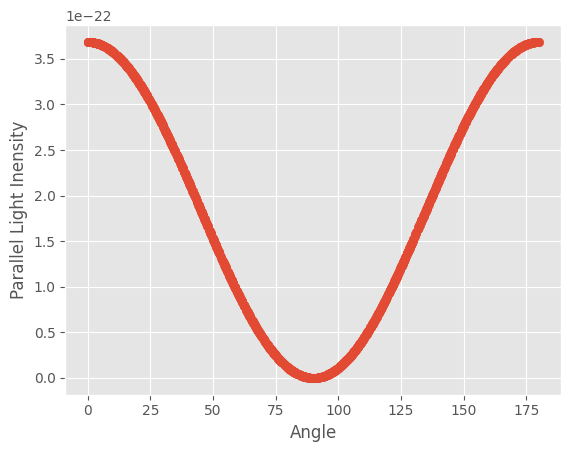

In [9]:
plt.xlabel('Angle')
plt.ylabel('Parallel Light Inensity')
plt.scatter(X_train,y_train)
plt.show()
#Our dataset is not linear

In [10]:
#Implemented Gaussian processes for regression
#As our data is not linear so we have used this gaussian process
kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

X_train = X_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
# Fit the model
gp.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [11]:
# From Scratch Implementation
# class GaussianProcessRegressor:
#     def __init__(self, kernel, noise=1e-4):
#         self.kernel = kernel
#         self.noise = noise
#         self.X_train = None
#         self.y_train = None
#         self.K = None
#         self.K_inv = None

#     def fit(self, X, y):
#         self.X_train = X
#         self.y_train = y
#         self.K = self.kernel(X, X) + self.noise * np.eye(len(X))
#         self.K_inv = np.linalg.inv(self.K)

#     def predict(self, X_test):
#         K_star = self.kernel(self.X_train, X_test)
#         y_pred_mean = K_star.T @ np.linalg.solve(self.K, self.y_train)
#         K_star_star = self.kernel(X_test, X_test)
#         y_pred_cov = K_star_star - K_star.T @ np.linalg.solve(self.K, K_star)
#         return y_pred_mean, np.sqrt(np.diag(y_pred_cov))

# # Assuming you have X_train and y_train defined earlier
# # Reshape the input arrays if needed
# X_train = X_train.reshape(-1, 1)
# y_train = y_train.reshape(-1, 1)

# # Define and train Gaussian Process Regressor
# kernel = lambda X1, X2: (1.0 * np.exp(-0.5 * (X1 - X2.T)**2 / 1.0**2))
# gp = GaussianProcessRegressor(kernel=kernel, noise=1e-4)
# gp.fit(X_train, y_train)


In [12]:
y_pred, sigma = gp.predict(X_test,return_std=True)

In [13]:
from sklearn.metrics import r2_score
#In regression problem we check r2 score for accuracy.
r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2) Score: {int(r2*100)} %")


R-squared (R2) Score: 99 %


In [14]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
#If you see the MSE the value is very less which is tending to zero.

Mean Squared Error (MSE): 7.305942161098764e-53


In [15]:
custom_value = float(input("Enter the angle value ")) #Taking the custom value for prediction
predicted_value =gp.predict([[custom_value]]) #Prediction for custom value
print(f"The predicted value of parallel Light intensity is : {predicted_value}")

Enter the angle value 12
The predicted value of parallel Light intensity is : [3.52632126e-22]


In [16]:
X

array([0.000e+00, 1.000e-01, 2.000e-01, ..., 1.798e+02, 1.799e+02,
       1.800e+02])

*Master Functions*

Enter no. of divisions of graph 
30
Select a mode: 
1.Slope 
2.Angle(single) 
3.Angle(dual)
4.Slope(dual)
Enter mode (1,2,3,4):
3
Enter larger angle: 
30
Enter smaller angle: 
20
Slope we are looking for is :  [-4.90359406e-24]
[0.1, 6.1000000000000005, 12.100000000000001, 18.1, 24.1, 30.1, 36.1, 42.1, 48.1, 54.1, 60.1, 66.10000000000001, 72.10000000000001, 78.10000000000001, 84.10000000000001, 90.10000000000001, 96.10000000000001, 102.10000000000001, 108.10000000000001, 114.10000000000001, 120.10000000000001, 126.10000000000001, 132.1, 138.1, 144.1, 150.1, 156.10000000000002, 162.10000000000002, 168.10000000000002, 174.10000000000002, 180.0] [3.685491630407847e-22, 3.64388596401356e-22, 3.523562075616676e-22, 3.3297786965182166e-22, 3.0710050902606046e-22, 2.7585509051708264e-22, 2.4060718884588365e-22, 2.0289730645369239e-22, 1.6437354615313965e-22, 1.2671958112687132e-22, 9.158107033030587e-23, 6.049373529853544e-23, 3.48162417460325e-23, 1.5670819355325782e-23, 3.894214954818694e-2

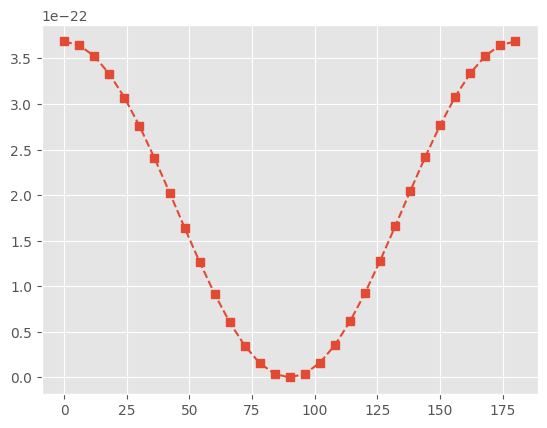

In [22]:
l=X.shape[0]-1
def slope(m,n):
  xn = []
  yn = []
  sl=[]

  for i in range(0,n+1):                                  # n number of divisons
        index = int(((l / n) * i) +1)
        if index==1801:
          index=1800
        xn.append(X[index])
        yn.append(y[index])                              # x , y saved for those divisons

  plt.plot(xn, yn, marker='s', linestyle='--')
  for i in range(0,n):
    sl.append((yn[i+1]-yn[i])/(xn[i+1]-xn[i]))           # slope
  min=np.min(sl)
  max=np.max(sl)
  # print(max)
  # print(min)
  print( xn , yn)


  if(m>min and m<max):
     nl = np.abs(np.array(sl) - m)
     minpos = np.argmin(nl)
     print("-----------The slope for the various divisions in the graph are ------------- \n")
     for i in sl:
      print(i)
     print("-----------The slope that matches the input in the graph are ------------- \n")
     print(sl[minpos] , " at position ", minpos+1)

     plt.show()

  else:
    print("The slope you have enetered is not possible for given particle\n")

def intensity(angle):
  prdicted_value =gp.predict([[angle]])
  return prdicted_value

def slopeCompare():
  n = int(input("Enter no. of divisions of graph \n"))
  print("Select a mode: \n1.Slope \n2.Angle(single) \n3.Angle(dual)\n4.Slope(dual)")
  x = int(input("Enter mode (1,2,3,4):\n"))
  if(x==1):
    m = float(input("Enter slope: \n"))
    slope(m,n)
  elif(x==2):
    angle = float(input("Enter angle: \n"))
    m = (intensity(angle+0.001)-intensity(angle-0.001))/(0.002)
    print("Slope we are looking for is : ",m)
    slope(m,n)
  elif(x==3):
    angle1 = float(input("Enter larger angle: \n"))
    angle2 = float(input("Enter smaller angle: \n"))
    m = (intensity(angle1)-intensity(angle2))/(angle1-angle2)
    print("Slope we are looking for is : ",m)
    slope(m,n)
  elif(x==4):
    s1=float(input("enter slope 1: \n"))
    s2=float(input("enter slope 2: \n"))
    slope((s1+s2)/2,n)
  else:
    print("Please Check Input")
slopeCompare()

In [18]:
12171

12171